# Final Project
Student : Mehdi Bordbar

In [1]:
!wget "https://ndownloader.figshare.com/articles/13909202/versions/1" -O files.zip

--2021-02-22 11:38:34--  https://ndownloader.figshare.com/articles/13909202/versions/1
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 54.72.238.132, 52.212.246.190, 108.128.236.202, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|54.72.238.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18392105 (18M) [application/zip]
Saving to: ‘files.zip’

files.zip           100%[===================>]  17.54M  14.9MB/s    in 1.2s    

2021-02-22 11:38:35 (14.9 MB/s) - ‘files.zip’ saved [18392105/18392105]



In [2]:
!unzip files.zip

Archive:  files.zip
 extracting: Dataset.zip             
 extracting: Image_Labels.csv        


In [ ]:
!unzip Dataset.zip

In [5]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import glob
from PIL import Image
from torch import nn
from torch import optim
import torchvision

In [8]:
classes = {0:'Dena_Plus' , 1:'MG' , 2:'peugeot_206' , 3:'Quick' , 4:'Samand_LX', 5:'Tiba_Hatchback'}
Classes_inv = {v: k for k, v in classes.items()}

class CarDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.classes = pd.read_csv(csv_file)
        self.dataset = glob.glob(root_dir + '*/*.jpg')
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image_path = self.dataset[idx]
        image_name = image_path.split("/")[-1]
        image = Image.open(image_path)
        image_info = self.classes.loc[self.classes['Image_name'] == image_name]
        target = image_info['Class'].item()
        target = Classes_inv[target]
        if self.transform:
            image = self.transform(image)
        return image , target

In [54]:
i_transform=transforms.Compose([transforms.ToTensor()])
Car_dataset = CarDataset(csv_file='Image_Labels.csv',root_dir='Dataset/',transform=i_transform)

df = pd.read_csv('Image_Labels.csv')
labels = df['Class'].tolist()

In [55]:
len(Car_dataset)

2155

In [56]:
train_set, val_set , test_set = torch.utils.data.random_split(Car_dataset, [1900 , 100 , 155])
train_loader = DataLoader(train_set , shuffle=True , num_workers= 4 , batch_size= 64)
val_loader = DataLoader(val_set , shuffle=False , num_workers= 0 , batch_size= 1)
test_loader = DataLoader(test_set , shuffle=False , num_workers= 0 , batch_size= 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

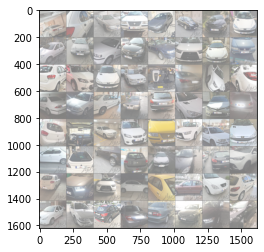

   MG    Tiba_Hatchback    Samand_LX    Samand_LX


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('    '.join('%5s' % classes[labels.tolist()[j]] for j in range(4)))

## Model Number 1 : ResNet50 pretrained by ImageNET

In [ ]:
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 6))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
epochs = 20
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"val loss: {test_loss/len(val_loader):.3f}.. "
                  f"val accuracy: {accuracy/len(val_loader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'DivarCar.pth')

Epoch 1/20.. Train loss: 3.582.. val loss: 1.949.. val accuracy: 0.220
Epoch 1/20.. Train loss: 1.757.. val loss: 1.574.. val accuracy: 0.490
Epoch 1/20.. Train loss: 1.593.. val loss: 1.454.. val accuracy: 0.460
Epoch 2/20.. Train loss: 1.457.. val loss: 1.302.. val accuracy: 0.580
Epoch 2/20.. Train loss: 1.366.. val loss: 1.202.. val accuracy: 0.590
Epoch 2/20.. Train loss: 1.260.. val loss: 1.068.. val accuracy: 0.670
Epoch 3/20.. Train loss: 1.128.. val loss: 1.048.. val accuracy: 0.610
Epoch 3/20.. Train loss: 1.057.. val loss: 1.037.. val accuracy: 0.600
Epoch 3/20.. Train loss: 1.150.. val loss: 0.957.. val accuracy: 0.680
Epoch 4/20.. Train loss: 1.048.. val loss: 0.861.. val accuracy: 0.740
Epoch 4/20.. Train loss: 1.041.. val loss: 0.958.. val accuracy: 0.560
Epoch 4/20.. Train loss: 1.022.. val loss: 0.895.. val accuracy: 0.730
Epoch 5/20.. Train loss: 0.939.. val loss: 0.878.. val accuracy: 0.700
Epoch 5/20.. Train loss: 0.889.. val loss: 0.902.. val accuracy: 0.730
Epoch 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred_list = []
y_gt_list = []

with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device),labels
      logps = model(inputs)
      y_pred_list.append(classes[np.argmax(logps[0].cpu().detach().numpy())])
      y_gt_list.append(classes[int(labels[0].cpu().detach().numpy())])
      # print('=====================================')
      # print(classes[int(labels[0].cpu().detach().numpy())])
      # print(classes[np.argmax(logps[0].cpu().detach().numpy())])

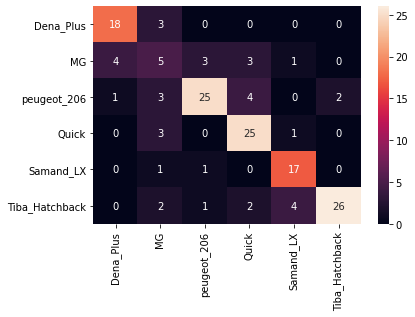

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_gt_list, y_pred_list)).rename(columns=classes, index=classes)

sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_gt_list, y_pred_list))

                precision    recall  f1-score   support

     Dena_Plus       0.78      0.86      0.82        21
            MG       0.29      0.31      0.30        16
         Quick       0.83      0.71      0.77        35
     Samand_LX       0.74      0.86      0.79        29
Tiba_Hatchback       0.74      0.89      0.81        19
   peugeot_206       0.93      0.74      0.83        35

      accuracy                           0.75       155
     macro avg       0.72      0.73      0.72       155
  weighted avg       0.76      0.75      0.75       155



## Model Number 2 : inception V3 pretrained by ImageNet

In [ ]:
models.inception_v3(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 6))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
epochs = 20
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"val loss: {test_loss/len(val_loader):.3f}.. "
                  f"val accuracy: {accuracy/len(val_loader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'DivarCar2.pth')

Epoch 1/20.. Train loss: 3.362.. val loss: 1.713.. val accuracy: 0.410
Epoch 1/20.. Train loss: 1.748.. val loss: 1.586.. val accuracy: 0.510
Epoch 1/20.. Train loss: 1.592.. val loss: 1.455.. val accuracy: 0.500
Epoch 2/20.. Train loss: 1.470.. val loss: 1.415.. val accuracy: 0.550
Epoch 2/20.. Train loss: 1.410.. val loss: 1.444.. val accuracy: 0.430
Epoch 2/20.. Train loss: 1.344.. val loss: 1.255.. val accuracy: 0.510
Epoch 3/20.. Train loss: 1.177.. val loss: 1.015.. val accuracy: 0.650
Epoch 3/20.. Train loss: 1.115.. val loss: 0.971.. val accuracy: 0.660
Epoch 3/20.. Train loss: 1.058.. val loss: 0.945.. val accuracy: 0.670
Epoch 4/20.. Train loss: 0.936.. val loss: 0.894.. val accuracy: 0.680
Epoch 4/20.. Train loss: 0.931.. val loss: 0.900.. val accuracy: 0.700
Epoch 4/20.. Train loss: 0.960.. val loss: 0.861.. val accuracy: 0.740
Epoch 5/20.. Train loss: 0.899.. val loss: 0.841.. val accuracy: 0.710
Epoch 5/20.. Train loss: 0.773.. val loss: 0.734.. val accuracy: 0.750
Epoch 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred_list = []
y_gt_list = []

with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device),labels
      logps = model(inputs)
      y_pred_list.append(classes[np.argmax(logps[0].cpu().detach().numpy())])
      y_gt_list.append(classes[int(labels[0].cpu().detach().numpy())])
      # print('=====================================')
      # print(classes[int(labels[0].cpu().detach().numpy())])
      # print(classes[np.argmax(logps[0].cpu().detach().numpy())])

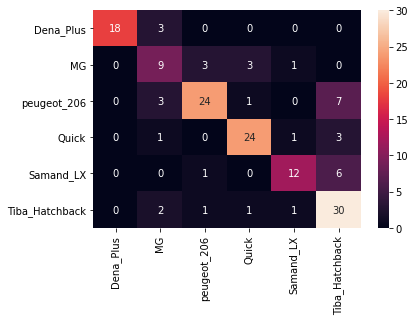

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_gt_list, y_pred_list)).rename(columns=classes, index=classes)

sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
print(classification_report(y_gt_list, y_pred_list))

                precision    recall  f1-score   support

     Dena_Plus       1.00      0.86      0.92        21
            MG       0.50      0.56      0.53        16
         Quick       0.83      0.69      0.75        35
     Samand_LX       0.83      0.83      0.83        29
Tiba_Hatchback       0.80      0.63      0.71        19
   peugeot_206       0.65      0.86      0.74        35

      accuracy                           0.75       155
     macro avg       0.77      0.74      0.75       155
  weighted avg       0.77      0.75      0.76       155



## Model Number 3 : Decision Tree

In [11]:
t_transform = transforms.Compose([
                                  transforms.Resize((16,16)),
                                  transforms.ToTensor()
])
dataset = CarDataset('Image_Labels.csv','Dataset/',t_transform)

In [60]:
train_set, val_set , test_set = torch.utils.data.random_split(dataset, [1900 , 100 , 155])
train_loader = DataLoader(train_set , shuffle=True , num_workers= 4 , batch_size= 1)
val_loader = DataLoader(val_set , shuffle=False , num_workers= 0 , batch_size= 1)
test_loader = DataLoader(test_set , shuffle=False , num_workers= 0 , batch_size= 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

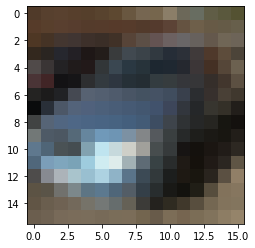

In [61]:
img,target = next(iter(dataloader))
plt.imshow(img[0].permute(1,2,0))

In [62]:
df = pd.DataFrame(columns=['Pixel_' + str(x) for x in range(256*3)] + ['target'])
for img,target in train_loader:
  img = torch.reshape(img[0] , (256*3,))
  new_data = pd.Series(img.tolist() + [classes[int(target)]], index = df.columns)
  df = df.append(new_data, ignore_index=True)
df.head(5)

,Pixel_0,Pixel_1,Pixel_2,Pixel_3,Pixel_4,Pixel_5,Pixel_6,Pixel_7,Pixel_8,Pixel_9,Pixel_10,Pixel_11,Pixel_12,Pixel_13,Pixel_14,Pixel_15,Pixel_16,Pixel_17,Pixel_18,Pixel_19,Pixel_20,Pixel_21,Pixel_22,Pixel_23,Pixel_24,Pixel_25,Pixel_26,Pixel_27,Pixel_28,Pixel_29,Pixel_30,Pixel_31,Pixel_32,Pixel_33,Pixel_34,Pixel_35,Pixel_36,Pixel_37,Pixel_38,Pixel_39,...,Pixel_729,Pixel_730,Pixel_731,Pixel_732,Pixel_733,Pixel_734,Pixel_735,Pixel_736,Pixel_737,Pixel_738,Pixel_739,Pixel_740,Pixel_741,Pixel_742,Pixel_743,Pixel_744,Pixel_745,Pixel_746,Pixel_747,Pixel_748,Pixel_749,Pixel_750,Pixel_751,Pixel_752,Pixel_753,Pixel_754,Pixel_755,Pixel_756,Pixel_757,Pixel_758,Pixel_759,Pixel_760,Pixel_761,Pixel_762,Pixel_763,Pixel_764,Pixel_765,Pixel_766,Pixel_767,target
0,0.513726,0.466667,0.270588,0.368627,0.513726,0.517647,0.498039,0.513726,0.454902,0.419608,0.419608,0.325490,0.435294,0.501961,0.560784,0.400000,0.321569,0.274510,0.184314,0.466667,0.486275,0.431373,0.447059,0.423529,0.317647,0.313726,0.329412,0.341176,0.243137,0.352941,0.552941,0.333333,0.294118,0.098039,0.188235,0.423529,0.337255,0.239216,0.270588,0.258824,...,0.631373,0.431373,0.545098,0.678431,0.172549,0.054902,0.058824,0.454902,0.443137,0.341176,0.415686,0.439216,0.811765,0.839216,0.874510,0.858824,0.772549,0.729412,0.725490,0.450980,0.094118,0.082353,0.082353,0.513726,0.435294,0.321569,0.392157,0.396078,0.780392,0.819608,0.854902,0.811765,0.721569,0.800000,0.666667,0.270588,0.105882,0.090196,0.086275,Dena_Plus
1,0.427451,0.509804,0.447059,0.576471,0.803922,0.803922,0.796078,0.800000,0.807843,0.815686,0.807843,0.533333,0.286275,0.180392,0.211765,0.215686,0.411765,0.494118,0.501961,0.545098,0.807843,0.807843,0.803922,0.796078,0.807843,0.823529,0.705882,0.368627,0.176471,0.105882,0.125490,0.137255,0.458824,0.470588,0.462745,0.505882,0.737255,0.717647,0.733333,0.643137,...,0.215686,0.192157,0.192157,0.188235,0.231373,0.278431,0.435294,0.686275,0.670588,0.635294,0.607843,0.580392,0.564706,0.560784,0.552941,0.556863,0.482353,0.478431,0.474510,0.427451,0.462745,0.498039,0.517647,0.682353,0.666667,0.670588,0.662745,0.662745,0.666667,0.674510,0.686275,0.666667,0.611765,0.678431,0.592157,0.619608,0.643137,0.631373,0.650980,Dena_Plus
2,0.741176,0.466667,0.215686,0.356863,0.356863,0.486275,0.466667,0.447059,0.423529,0.407843,0.400000,0.223529,0.270588,0.337255,0.411765,0.466667,0.729412,0.541176,0.376471,0.313726,0.282353,0.560784,0.564706,0.517647,0.474510,0.474510,0.494118,0.396078,0.529412,0.643137,0.666667,0.588235,0.603922,0.549020,0.607843,0.372549,0.321569,0.556863,0.533333,0.478431,...,0.223529,0.239216,0.219608,0.360784,0.501961,0.501961,0.509804,0.737255,0.717647,0.674510,0.635294,0.603922,0.537255,0.458824,0.396078,0.376471,0.356863,0.407843,0.470588,0.458824,0.490196,0.505882,0.509804,0.729412,0.713726,0.686275,0.666667,0.654902,0.647059,0.623529,0.588235,0.545098,0.482353,0.564706,0.537255,0.556863,0.560784,0.619608,0.756863,Dena_Plus
3,0.368627,0.262745,0.133333,0.176471,0.254902,0.286275,0.333333,0.180392,0.086275,0.086275,0.152941,0.109804,0.098039,0.066667,0.149020,0.200000,0.376471,0.400000,0.482353,0.627451,0.537255,0.356863,0.278431,0.207843,0.160784,0.149020,0.254902,0.196078,0.160784,0.086275,0.145098,0.301961,0.180392,0.172549,0.215686,0.435294,0.356863,0.188235,0.156863,0.149020,...,0.117647,0.086275,0.058824,0.058824,0.070588,0.109804,0.121569,0.172549,0.172549,0.176471,0.172549,0.164706,0.168627,0.172549,0.180392,0.172549,0.149020,0.129412,0.117647,0.098039,0.117647,0.164706,0.137255,0.168627,0.172549,0.172549,0.172549,0.172549,0.168627,0.164706,0.180392,0.184314,0.164706,0.160784,0.137255,0.160784,0.184314,0.172549,0.149020,Samand_LX
4,0.184314,0.211765,0.200000,0.239216,0.396078,0.588235,0.639216,0.576471,0.525490,0.564706,0.580392,0.615686,0.631373,0.568627,0.552941,0.525490,0.490196,0.411765,0.258824,0.294118,0.376471,0.494118,0.568627,0.580392,0.611765,0.611765,0.607843,0.627451,0.643137,0.537255,0.486275,0.384314,0.541176,0.443137,0.403922,0.505882,0.470588,0.462

In [90]:
import pandas as pd
from sklearn import tree
import pydotplus
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.image as pltim
import matplotlib.image as pltimg
import numpy as np

In [64]:
X = df.iloc[:,0:768]
Y = df.iloc[:,-1]

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.829817 to fit



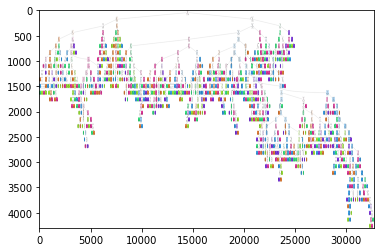

In [82]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, Y)
data = tree.export_graphviz(dtree, out_file=None, feature_names=X.columns,class_names= list(classes.values()),filled=True, rounded=True,  
                      special_characters=True)
graph = pydotplus.graph_from_dot_data(data)
graph.write_png('mydecisiontree.png')

img=pltimg.imread('mydecisiontree.png')
imgplot = plt.imshow(img , aspect='auto')
plt.show()

In [83]:
pred = []
gt = []
for img,target in test_loader:
  img = torch.reshape(img[0] , (256*3,))
  new_data = pd.Series(img.tolist(), index = df.columns[0:768])
  gt.append(classes[int(target)])
  pred.append(dtree.predict([new_data])[0])

In [84]:
print(gt)

['Samand_LX', 'peugeot_206', 'MG', 'peugeot_206', 'Dena_Plus', 'peugeot_206', 'Dena_Plus', 'peugeot_206', 'Samand_LX', 'Quick', 'Quick', 'Tiba_Hatchback', 'Samand_LX', 'Tiba_Hatchback', 'peugeot_206', 'Dena_Plus', 'Dena_Plus', 'peugeot_206', 'peugeot_206', 'Samand_LX', 'peugeot_206', 'Quick', 'MG', 'Tiba_Hatchback', 'Quick', 'Quick', 'peugeot_206', 'peugeot_206', 'MG', 'Tiba_Hatchback', 'peugeot_206', 'Samand_LX', 'Quick', 'Dena_Plus', 'Dena_Plus', 'peugeot_206', 'Quick', 'MG', 'peugeot_206', 'Quick', 'Dena_Plus', 'Dena_Plus', 'Samand_LX', 'Tiba_Hatchback', 'peugeot_206', 'Quick', 'peugeot_206', 'MG', 'Samand_LX', 'Dena_Plus', 'Tiba_Hatchback', 'peugeot_206', 'Samand_LX', 'Samand_LX', 'peugeot_206', 'Quick', 'Dena_Plus', 'Samand_LX', 'Samand_LX', 'peugeot_206', 'peugeot_206', 'Tiba_Hatchback', 'Dena_Plus', 'Tiba_Hatchback', 'Tiba_Hatchback', 'peugeot_206', 'Quick', 'Dena_Plus', 'Dena_Plus', 'Tiba_Hatchback', 'Dena_Plus', 'Quick', 'Samand_LX', 'Dena_Plus', 'Tiba_Hatchback', 'peugeot_206

In [85]:
print(pred)

['Dena_Plus', 'Samand_LX', 'Dena_Plus', 'Samand_LX', 'peugeot_206', 'Samand_LX', 'Tiba_Hatchback', 'Dena_Plus', 'Samand_LX', 'Dena_Plus', 'Quick', 'peugeot_206', 'Samand_LX', 'Quick', 'MG', 'Quick', 'Dena_Plus', 'peugeot_206', 'Dena_Plus', 'Quick', 'Samand_LX', 'Samand_LX', 'Dena_Plus', 'peugeot_206', 'Samand_LX', 'Dena_Plus', 'Dena_Plus', 'Dena_Plus', 'Quick', 'Dena_Plus', 'Samand_LX', 'Samand_LX', 'Quick', 'Dena_Plus', 'peugeot_206', 'MG', 'Tiba_Hatchback', 'Samand_LX', 'Samand_LX', 'Tiba_Hatchback', 'Quick', 'Dena_Plus', 'Tiba_Hatchback', 'peugeot_206', 'peugeot_206', 'Samand_LX', 'Quick', 'Samand_LX', 'Samand_LX', 'Dena_Plus', 'Quick', 'peugeot_206', 'Tiba_Hatchback', 'Dena_Plus', 'peugeot_206', 'peugeot_206', 'Dena_Plus', 'Samand_LX', 'Samand_LX', 'Samand_LX', 'peugeot_206', 'Quick', 'Dena_Plus', 'Samand_LX', 'Samand_LX', 'peugeot_206', 'Tiba_Hatchback', 'peugeot_206', 'Dena_Plus', 'peugeot_206', 'Samand_LX', 'Samand_LX', 'Samand_LX', 'Samand_LX', 'Samand_LX', 'peugeot_206', 'peug

In [92]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

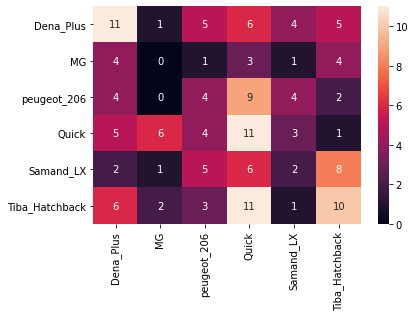

In [93]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(gt, pred)).rename(columns=classes, index=classes)

sns.heatmap(confusion_matrix_df, annot=True)

In [94]:
print(classification_report(gt, pred))

                precision    recall  f1-score   support

     Dena_Plus       0.34      0.34      0.34        32
            MG       0.00      0.00      0.00        13
         Quick       0.18      0.17      0.18        23
     Samand_LX       0.24      0.37      0.29        30
Tiba_Hatchback       0.13      0.08      0.10        24
   peugeot_206       0.33      0.30      0.32        33

      accuracy                           0.25       155
     macro avg       0.21      0.21      0.21       155
  weighted avg       0.24      0.25      0.24       155

